In [2]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

import queue
from typing import Any, Optional, List
import asyncio
import nest_asyncio
nest_asyncio.apply()

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext
from qubx.impl.ccxt_trading import CCXTSyncTradingConnector
from qubx.impl.ccxt_connector import CCXTDataConnector
from qubx.utils.runner import get_account_config
from qubx.pandaz import scols

from xincubator.models.nimble.aoi_nimblers import NimbleI_AOI


# path to pythonpath /mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments
sys.path.append('/mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments')


def clear_queue(q: queue.Queue):
    while not q.empty():
        try:
            q.get_nowait()
        except queue.Empty:
            continue


 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. 0.1.90
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In file included from /mnt/HC_Volume_100695026/home/shared/.conda/envs/xincubator/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /mnt/HC_Volume_100695026/home/shared/.conda/envs/xincubator/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/HC_Volume_100695026/home/shared/.conda/envs/xincubator/lib/python3.11/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from .pyxbld/temp.linux-x86_64-cpython-311/mnt/HC_Volume_100695026/home/shared/devs/Qubx/src/qubx/ta/indicators.c:1205:
/mnt/HC_Volume_100695026/home/shared/.conda/envs/xincubator/lib/python3.11/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
.pyxbld/temp.linux-x86_64-cpython-311/mnt/HC

## Testing trade feed implementation

Let's first take a look at the examples from ccxt how they listen to trades https://github.com/ccxt/ccxt/tree/master/examples/ccxt.pro/py

In [2]:
import ccxt.pro as cxp
from asyncio import gather, run


async def symbol_loop(exchange, symbol):
    print('Starting the', exchange.id, 'symbol loop with', symbol)
    while True:
        try:
            trades = await exchange.watch_trades(symbol)
            now = exchange.milliseconds()
            print(exchange.iso8601(now), exchange.id, symbol, len(trades), trades[-1]['price'])
        except Exception as e:
            print(str(e))
            # raise e  # uncomment to break all loops in case of an error in any one of them
            break  # you can break just this one loop if it fails


async def exchange_loop(exchange_id, symbols):
    print('Starting the', exchange_id, 'exchange loop with', symbols)
    exchange = getattr(cxp, exchange_id)({
        'newUpdates': True,  # https://github.com/ccxt/ccxt/wiki/ccxt.pro.manual#incremental-data-structures
    })
    loops = [symbol_loop(exchange, symbol) for symbol in symbols]
    await gather(*loops)
    await exchange.close()


async def main():
    exchanges = {
        'kraken': ['BTC/USD'],
        'binanceusdm': ['BTCUSDT'],
        'binance': ['BTCUSDT'],
    }
    loops = [exchange_loop(exchange_id, symbols) for exchange_id, symbols in exchanges.items()]
    await gather(*loops)


# await main()

Now let's debug the strategy context with trade feed

In [3]:
from pathlib import Path
from strats.tradefeed import TradeTestStrat

CONFIG_PATH = Path("/mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments/configs")

auth = get_account_config(
    "binance-mde", str(CONFIG_PATH / ".env.fishermen2")
)

In [3]:
brok = CCXTSyncTradingConnector('binance', **acc)
data = CCXTDataConnector('binance', brok, **acc)
brok.acc.get_balances()

2024-07-07 23:00:19.546 [ ℹ️ ] BINANCE loading ...
2024-07-07 23:00:22.864 [ ℹ️ ] Loading account data for Binance
2024-07-07 23:00:23.108 [ ℹ️ ] BINANCE initialized - current time 2024-07-07T23:00:23.108902000


{'BTC': (0.00401322, 0.0)}

### Simple strategy wrapper

In [13]:
symbols = ['LINK', 'XRP', 'PEPE'] 
instruments = [lookup.find_instrument('BINANCE', s, 'USDT') for s in symbols]

channel = cc.get_communication_channel()
if not channel.control.is_set():
    channel.start()

ctx = StrategyContext(
    TradeTestStrat(), dict(
        capital_invested=100,
        trading_allowed=False
    ), 
    data, brok, instruments=instruments,  # type: ignore
    md_subscription=dict(type='trades', timeframe='1Sec', nback=100),
    # every second
    trigger_spec="* * * * * *"
)
S = ctx.strategy

try:
    ctx.start(blocking=True)
except KeyboardInterrupt:
    logger.info("Stopped by user")
finally:
    ctx.stop()
    channel.stop()
    clear_queue(channel.queue)

2024-07-07 21:11:06.054 [ ⚠️ ] qubx.core.loggers:__init__:324 - Log writer is not defined - strategy activity will not be saved !


2024-07-07 21:11:06.055 [ ℹ️ ] (StrategyContext) set strategy parameters:
	set capital_invested <- 100
	set trading_allowed <- False
2024-07-07 21:11:06.057 [ 🐞 ] Next (time_event) event scheduled at 2024-07-07 21:11:07
2024-07-07 21:11:06.782 [ ℹ️ ] (StrategyContext) Subscribing to trades updates using {'timeframe': '1Sec', 'nback': 100} for 
	['LINKUSDT', 'XRPUSDT', 'PEPEUSDT'] 
2024-07-07 21:11:06.783 [ ℹ️ ] Subscribed on trades updates for 3 symbols: 
		['LINKUSDT', 'XRPUSDT', 'PEPEUSDT']
2024-07-07 21:11:06.786 [ ℹ️ ] > Started with capital 100
2024-07-07 21:11:06.790 [ ℹ️ ] (StrategyContext) Start processing market data
2024-07-07 21:11:06.791 [ ℹ️ ] Listening to trades for LINKUSDT 1s 100...
2024-07-07 21:11:06.792 [ ℹ️ ] (StrategyContext) strategy is started
2024-07-07 21:11:06.796 [ ℹ️ ] Listening to trades for XRPUSDT 1s 100...
2024-07-07 21:11:06.799 [ ℹ️ ] Listening to trades for PEPEUSDT 1s 100...
2024-07-07 21:11:07.022 [ ⚠️ ] qubx.core.strategy:_process_incoming_data:411

2024-07-07 21:11:33.281 [ 🐞 ] Scheduler is stopped 


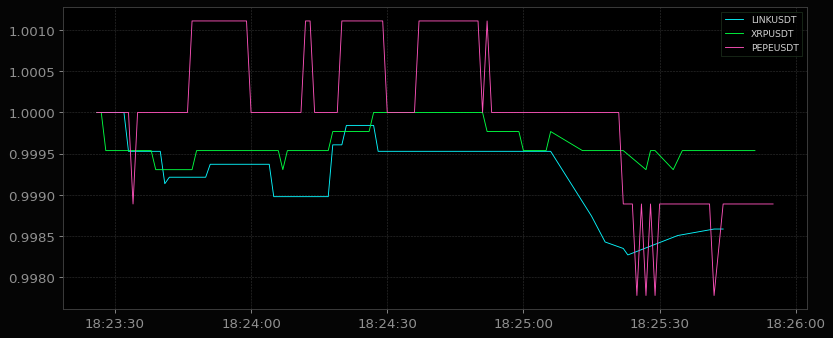

In [6]:
N = lambda x: x / x.iloc[0]
for s, hh in S.ohlcs('1Sec').items():
    plt.plot(N(hh.close), label=s)
plt.legend();

### Try out running nimble AOI detection live

In [27]:
brok = CCXTSyncTradingConnector('binance', **acc)
data = CCXTDataConnector('binance', brok, **acc)

symbols = ['SOL'] 
instruments = [lookup.find_instrument('BINANCE', s, 'USDT') for s in symbols]

channel = cc.get_communication_channel()
if not channel.control.is_set():
    channel.start()

try:
    ctx = StrategyContext(
        NimbleI_AOI(), dict(
            capital_invested=100,
            trading_allowed=False
        ), 
        data, brok, instruments=instruments,  # type: ignore
        md_subscription=dict(type='trades', timeframe='1Sec', nback=100),
        # every 10 seconds
        trigger_spec="* * * * * */10"
    )
    S = ctx.strategy
    ctx.start(blocking=True)
except KeyboardInterrupt:
    logger.info("Stopped by user")
finally:
    ctx.stop()
    channel.stop()
    clear_queue(channel.queue)

2024-07-07 23:12:56.672 [ ℹ️ ] BINANCE loading ...
2024-07-07 23:13:00.374 [ ℹ️ ] Loading account data for Binance
2024-07-07 23:13:00.619 [ ℹ️ ] BINANCE initialized - current time 2024-07-07T23:13:00.619354000
2024-07-07 23:13:00.620 [ ⚠️ ] qubx.core.loggers:__init__:324 - Log writer is not defined - strategy activity will not be saved !
2024-07-07 23:13:00.621 [ ℹ️ ] (StrategyContext) set strategy parameters:
	set capital_invested <- 100
	set trading_allowed <- False
2024-07-07 23:13:00.622 [ 🐞 ] Next (time_event) event scheduled at 2024-07-07 23:13:10
2024-07-07 23:13:00.857 [ ℹ️ ] (StrategyContext) Subscribing to trades updates using {'timeframe': '1Sec', 'nback': 100} for 
	['SOLUSDT'] 
2024-07-07 23:13:00.858 [ ℹ️ ] Subscribed on trades updates for 1 symbols: 
		['SOLUSDT']
2024-07-07 23:13:00.860 [ ℹ️ ] > Started with capital 100
2024-07-07 23:13:00.860 [ ℹ️ ] Listening to trades for SOLUSDT 1s 100...
2024-07-07 23:13:00.862 [ ℹ️ ] (StrategyContext) Start processing market data


2024-07-07 23:13:24.916 [ 🐞 ] Scheduler is stopped 
